# Cross Validation Analysis MobileNet V2

In this notebook, the MobileNet V2 network is analyzed on the orange disease dataset on the following points:

- Evaluate stability of the model: If the model performs consistently across folds, it suggests that the model is roboust and less sensitive to fluctuations in the data.
- Prevent overfitting: Training the model on different subsets of the data and validating it to unseen data can prevent overfitting
- Optimize hyperparameter: Most hyperparameters are chosen based on common choices. Only the number of epochs are chosen based on the cross validation analysis.

Why not using a fixed 80/20 split?

- The dataset is rather small with less than a thousand samples. With cross validation, it is ensured, that the model has seen all data. 
- Less prone to overfitting
- Cross validation gives a better estimate on how the model performs on unseen data

In [25]:
from PIL import Image
from torchvision import transforms, models
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset, Subset
import os
import copy
from pathlib import Path
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns

import sys
sys.path.append('../src')  # Adjust the path as necessary
from orange_disease_dataset import OrangeDiseaseDataset
from results_cross_validation import ResultsCrossValidation


data_dir = "../data/train"
labels = ['fresh','blackspot','canker','grenning']

## Transform dataset

Before the input data is applied to the network, it needs to be preprocessed. Therefore, the pytorch transform function is used with the following operations:

- As discussed in the data_analysis notebook, the images need to be resized to all have the same resolution. Based on the scatter plot, a pixel size of 256 x 256 is used.
- On the following page (https://pytorch.org/hub/pytorch_vision_mobilenet_v2/), it is suggested to normalize the images. This is required in order to start with a pretrained model.
- To prevent overfitting across epochs, the data is randomly flipped and rotated.
- Moreover, GaussianBlur and ColorJitter is applied to prevent overfitting. However, these two operations should be applied with caution -> Not in use in final version

In [26]:
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Resize((256, 256)),  # Resize images
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
    transforms.RandomVerticalFlip(),  # Randomly flip images vertically
    transforms.RandomRotation(360),  # Randomly rotate images by up to 360 degrees
    #transforms.GaussianBlur(kernel_size=(5,9), sigma=(0.1,5)),
    #transforms.ColorJitter(brightness=.5, hue=.3),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),  # Normalize images
])

## Load dataset

We load that dataset into a class called OrangeDiseaseDataset that contains all images and corresponding labels. 

In [27]:
# Create dataset
dataset = OrangeDiseaseDataset(data_dir, labels, transform=transform)

print(f"{len(dataset)} images are loaded")

991 images are loaded


## Split dataset into training and validation

We use a k value of 5 for the cross validation. This result in an 80/20 split. 

The batch size is chosen to be 64, which is a common choice for small to medium size models and datasets. Compared to a batch size of 32, less noise behaviour of training and validation loss was observed.

In [28]:
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
batch_size = 64

## Load Model

The MobileNet V2 model is loaded with pretrained labels. This can massively reduce time to convergence. Only the final fully connected layer of the network is adapted to fit the number of outputs/categories. 

Loss function: Cross entropy loss is used as it is the most common choise for classification taks. 

Optimizer: The Adam (Adaptive Moment Estimation) is used with default parameter to compute the learning rate. It is a popular choice as it often works well out of the box and combines advantages of both momentum and adaptive learning rates. 

Finally the model is loaded into the GPU if available.

In [29]:
# Move model to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Used device: {device}")

# Load MobileNet v2 model
def get_model():
    model = models.mobilenet_v2(weights='MobileNet_V2_Weights.DEFAULT')

    # Modify the final layer to match the number of classes
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, len(labels))
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())

    return model, optimizer, criterion, device

Used device: cuda:0


## Train the model

In this section the model is trained on the dataset. In order to find the optimal value for the number of epochs, we store results on the validation set for each epoch on each fold.


In [30]:
# Initialize variables to collect results
all_fold_reports = []
all_fold_conf_matrices = []
num_epochs = 8

results=ResultsCrossValidation(num_epochs=num_epochs, num_folds = n_splits)

epoch_performance = np.empty((num_epochs, n_splits), dtype=float)

# K-Fold Cross Validation
for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
    print(f'Fold {fold + 1}')
    
    # Split dataset
    train_subset = Subset(dataset, train_idx)
    val_subset = Subset(dataset, val_idx)
    
    # Create data loaders
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)


    model, optimizer, criterion, device = get_model()
    
    # Training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, target_names in train_loader:
            inputs, target_names = inputs.to(device), target_names.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, target_names)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            total += target_names.size(0)
            correct += (preds == target_names).sum().item()
        
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct / total
    
        # Validate the model
        model.eval()

        preds_epoch = []
        labels_epoch = []
        loss_epoch = []
        running_loss = 0
        with torch.no_grad():
            for inputs, target_names in val_loader:
                inputs, target_names = inputs.to(device), target_names.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, target_names)
                total += target_names.size(0)
                correct += (preds == target_names).sum().item()
                preds_epoch.extend(preds.cpu().tolist())
                labels_epoch.extend(target_names.cpu().tolist())
                running_loss += loss.item()
        
        results.addPredictions(fold=fold, epoch=epoch, predictions = copy.deepcopy(preds_epoch))
        results.addLabels(fold=fold, epoch=epoch, labels = copy.deepcopy(labels_epoch))
        results.addLoss(fold=fold, epoch=epoch, loss=running_loss/len(val_loader))
        accuracy = 100 * correct / total
        epoch_performance[epoch, fold] = accuracy
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}, Training Accuracy: {100*epoch_acc:.2f}%, Validation Accuracy: {accuracy:.2f}%')


Fold 1
Epoch 1/8, Training Loss: 0.3206, Training Accuracy: 91.41%, Validation Accuracy: 92.33%
Epoch 2/8, Training Loss: 0.0651, Training Accuracy: 97.22%, Validation Accuracy: 97.07%
Epoch 3/8, Training Loss: 0.0356, Training Accuracy: 98.74%, Validation Accuracy: 98.79%
Epoch 4/8, Training Loss: 0.0538, Training Accuracy: 98.74%, Validation Accuracy: 98.69%
Epoch 5/8, Training Loss: 0.0458, Training Accuracy: 98.99%, Validation Accuracy: 98.99%
Epoch 6/8, Training Loss: 0.0337, Training Accuracy: 98.61%, Validation Accuracy: 98.69%
Epoch 7/8, Training Loss: 0.0301, Training Accuracy: 99.24%, Validation Accuracy: 99.09%
Epoch 8/8, Training Loss: 0.0298, Training Accuracy: 98.99%, Validation Accuracy: 98.89%
Fold 2
Epoch 1/8, Training Loss: 0.3767, Training Accuracy: 87.64%, Validation Accuracy: 89.61%
Epoch 2/8, Training Loss: 0.0335, Training Accuracy: 99.12%, Validation Accuracy: 98.39%
Epoch 3/8, Training Loss: 0.0735, Training Accuracy: 97.86%, Validation Accuracy: 97.68%
Epoch 4

## Plot average validation loss and accuracy across epochs



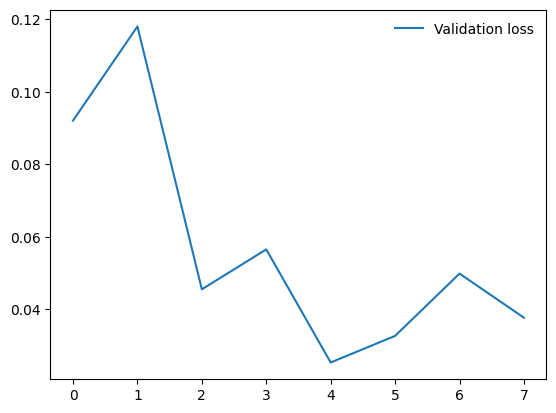

In [31]:

validation_losses = []
validation_accuracy = []
for epoch in range(num_epochs):
  validation_accuracy.append(results.getAccuracyEpoch(epoch))
  validation_losses.append(results.getValidationLossEpoch(epoch))

# Plot training and validation loss
plt.plot(validation_losses, label='Validation loss')
#plt.plot(validation_accuracy, label='Validation accuracy')
plt.legend(frameon=False)
plt.show()


Based on the validation loss, we decide to use 5 training epochs.

In [34]:
epoch = 4

# Generate classification report and confusion matrix
for fold in range(n_splits):
    print(f"Classification report for fold {fold}:")
    print(classification_report(results.labels[epoch][fold], results.predictions[epoch][fold], target_names=labels))
    


Classification report for fold 0:
              precision    recall  f1-score   support

       fresh       1.00      1.00      1.00        50
   blackspot       0.95      1.00      0.97        38
      canker       1.00      0.95      0.97        39
    grenning       1.00      1.00      1.00        72

    accuracy                           0.99       199
   macro avg       0.99      0.99      0.99       199
weighted avg       0.99      0.99      0.99       199

Classification report for fold 1:
              precision    recall  f1-score   support

       fresh       1.00      1.00      1.00        64
   blackspot       1.00      0.96      0.98        45
      canker       0.95      1.00      0.97        35
    grenning       1.00      1.00      1.00        54

    accuracy                           0.99       198
   macro avg       0.99      0.99      0.99       198
weighted avg       0.99      0.99      0.99       198

Classification report for fold 2:
              precision    r

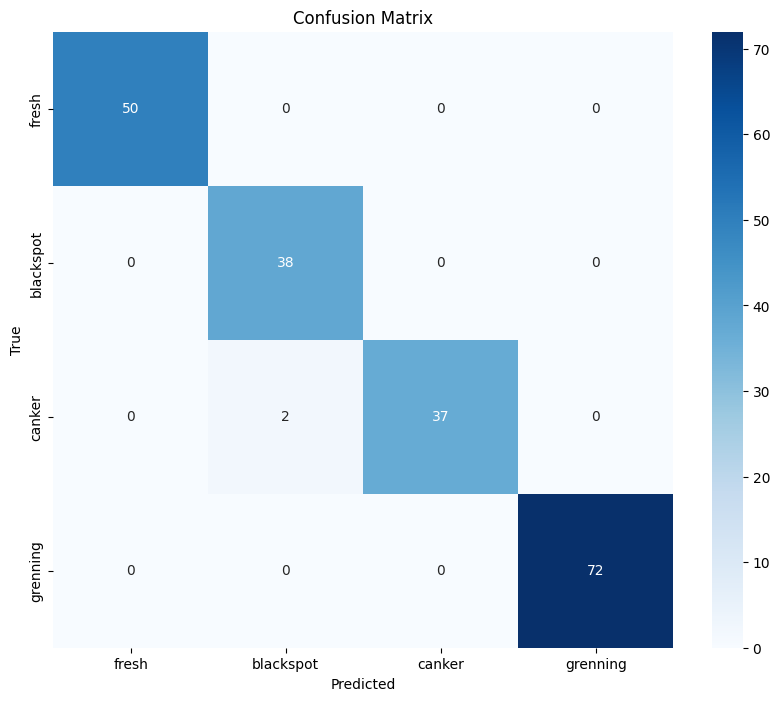

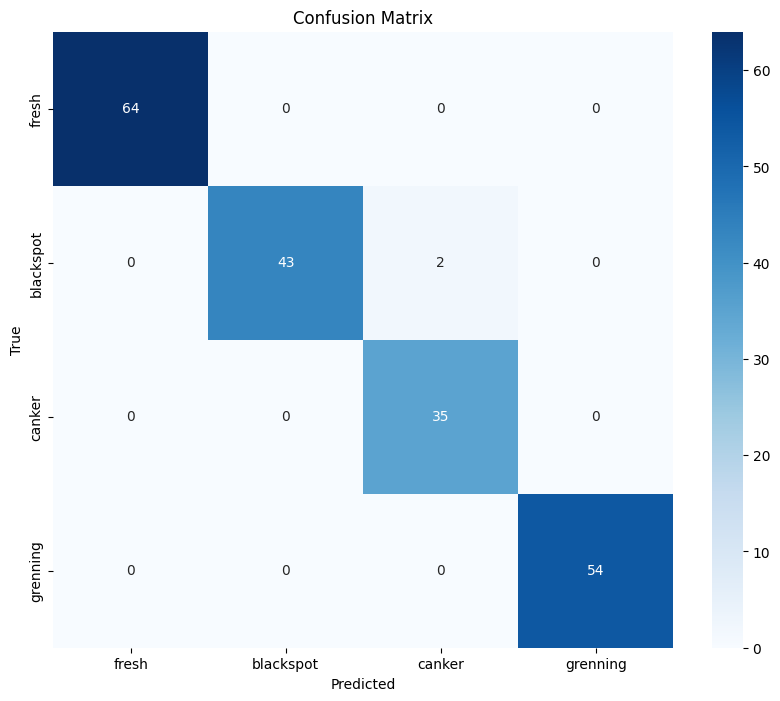

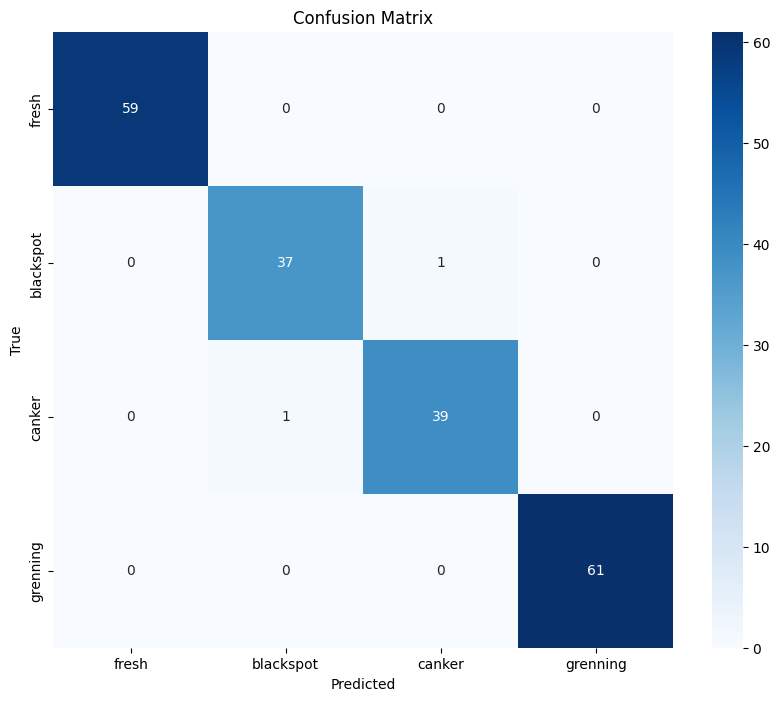

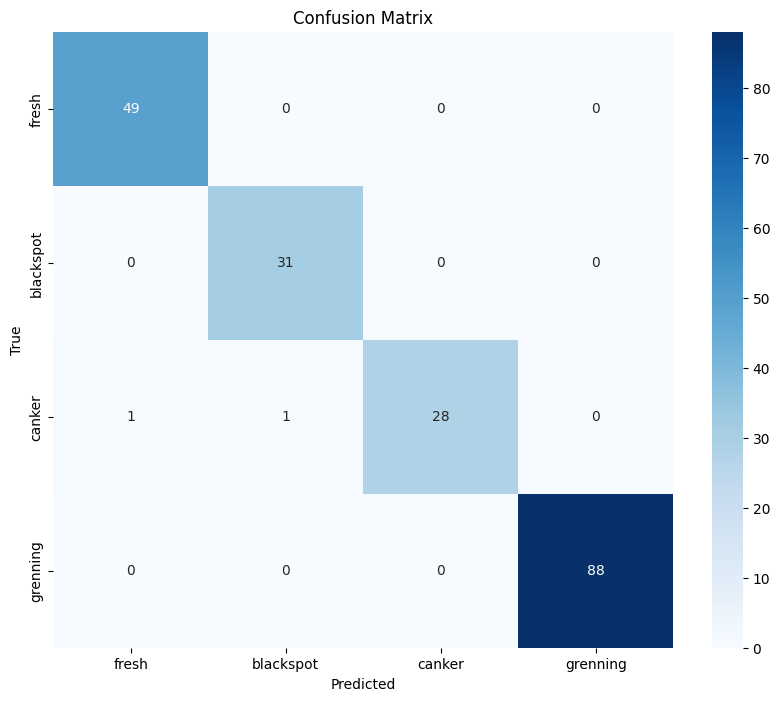

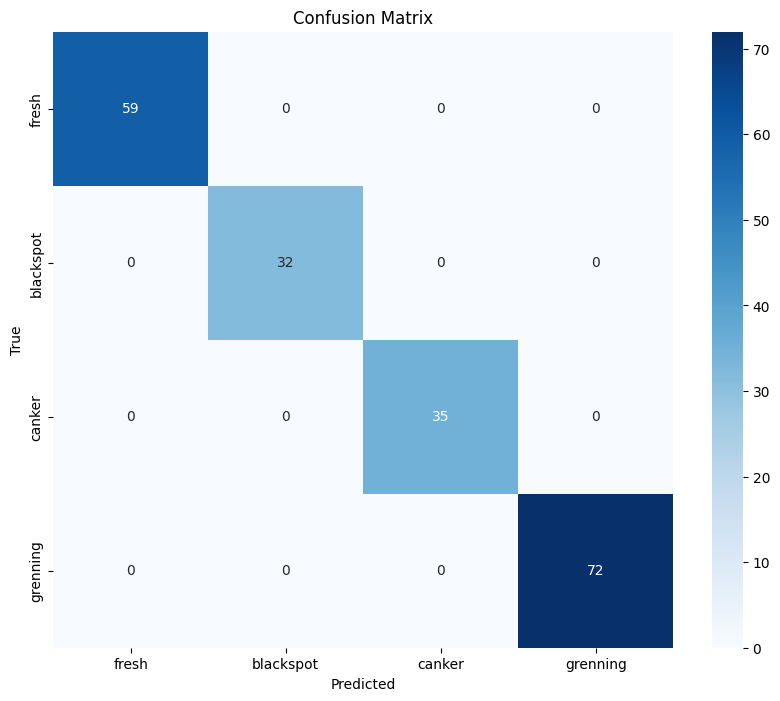

In [35]:
for fold in range(n_splits):
    conf_matrix = confusion_matrix(results.labels[epoch][fold], results.predictions[epoch][fold], labels=[0, 1, 2, 3])
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()



## Train the final model

In [37]:
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Training the model
num_epochs = 5
train_losses = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
    
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)
    
    model.eval()

    
    print(f"Epoch {epoch+1}/{num_epochs}.. "
          f"Train loss: {train_loss:.3f}.. ")
    
# Save the model
torch.save(model.state_dict(), f'../models/cross_validation_mobilenet_v2_final.pth')

Epoch 1/5.. Train loss: 0.023.. 
Epoch 2/5.. Train loss: 0.017.. 
Epoch 3/5.. Train loss: 0.024.. 
Epoch 4/5.. Train loss: 0.021.. 
Epoch 5/5.. Train loss: 0.023.. 
